# Modelo de Identificação de Parcialidade em Notícias Jornalísticas


### Importe das bibliotecas e carregamento das funções necessárias
- Arquivos com os dados necessários salvos no GoogleDrive


In [ ]:
"""
Mapeamento dos Arquivos
"""

BASE_GROUND_TRUTH = '/content/drive/MyDrive/Colab Notebooks/base_ground_truth.csv'

TRAINING = '/content/drive/MyDrive/Colab Notebooks/base_training.csv'
TRAINING_NAIVE_BAYES = '/content/drive/MyDrive/Colab Notebooks/base_training_naive_bayes.csv'

MODEL_GENERATOR = False
MODEL_IN = '/content/drive/MyDrive/Colab Notebooks/model_naive_bayes_01.wv'
MODEL_OUT = '/content/drive/MyDrive/Colab Notebooks/model_naive_bayes_01.wv'

HISTORY_RESULTS = '/content/drive/MyDrive/Colab Notebooks/history_results_naive_bayes_01.csv'

WORD2VEC_S50 = '/content/drive/MyDrive/Colab Notebooks/word2vec_s50.txt'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# coding: utf-8

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from wordcloud import WordCloud

from gensim.models import KeyedVectors

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, SpatialDropout1D, Bidirectional, Dropout
from keras.callbacks import EarlyStopping, CSVLogger

from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')

stopWords = set(stopwords.words('portuguese'))

"""
É descartado a palavra Não das StopWords pelo seu impacto no sentido da frase.
"""
stopWords.discard('não')



# Carregar o Word Embeddings Pré-Treinadas
Word2Vec = KeyedVectors.load_word2vec_format(WORD2VEC_S50)

MAX_NB_WORDS = len(Word2Vec.vocab)
EMBEDDING_DIM = 50

print("\nTamanhos dos vocabulários:\n -> Word2Vec - " + str(MAX_NB_WORDS))



def clean_text(text):
    """
    Realiza a preparação do texto para ser utilizada
    Removendo pontuações, links, aspas e tornando tadas as palavras em minúsculo
    Removendo as StopWords
    """

    text = re.sub(r'[^\w\s$]|http\S+','', text).lower()
    text = text.replace(r'/[\'"]+/g', '')
    text = ' '.join(word for word in text.split() if word not in stopWords)
    
    return text

def create_embedding_matrix(vocab, n_words, emb_size):
    """
    Transformar o Word2Vec em uma matrix
    """

    pret_embedding = {}

    # Retorna uma nova matriz de forma e tipo fornecidos, preenchida com zeros.
    # n_words - Tamanho da matriz
    # emb_size - Comprimento de zeros
    embedding_matrix = np.zeros((n_words, emb_size))
    count = 0

    # Dicionário com todos os ids e palavras do embedding pré-treinado
    # Chave como a palavra buscada e Value como a chave de localização no Word2Vec
    for index, word in enumerate(vocab.index2word):
        pret_embedding[word] = index

    # Construindo a embedding_matrix do embedding pré-treinado
    for item in pret_embedding.items():
        if item[1] < n_words:
            count += 1
            embedding_vector = vocab.word_vec(item[0])
            
            if embedding_vector is not None:
                embedding_matrix[item[1]] = embedding_vector
    
    return embedding_matrix

def create_x(tokens, embedding_model):
    """
    Buscar a localização dos tokens dentro do Word2Vec
    """

    list_x = []
    for token in tokens:
        if(token in embedding_model.vocab):
            list_x.append(embedding_model.vocab[token].index)
        
    return list_x

def predictModel(text, labels, Word2Vec):
    """
    Prepara um texto e analiza-lo com o Modelo gerado
    """

    text = re.sub(r'[^\w\s$]|http\S+','', text).lower()
    text = word_tokenize(text)
    text = list(filter(lambda text: text not in stopWords, text))
    
    X = create_x(text, Word2Vec)
    
    pred = model.predict([X])

    return labels[np.argmax(pred)]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Tamanhos dos vocabulários:
 -> Word2Vec - 929606


### Preparação da Base de Treinamento

In [ ]:
# TRAINING -> Base gerada a partir da analise do SentiStrength
# TRAINING_NAIVE_BAYES -> Base gerada a partir da analise do Naive Bayes

train = pd.read_csv(TRAINING_NAIVE_BAYES , sep=';', index_col=None, names=['article','type'])
train.head(2)


,article,type
0,Relator propõe renegociação de dívida de produ...,impartial
1,Deputado cearense lamenta aprovação e aposta e...,impartial


In [ ]:
print("\nTamanhos da Base:\n -> Treinamento - " + str(len(train)))

labels = train['type'].value_counts().axes[0].tolist()
value_counts = train['type'].value_counts()

print("\nDetalhes:" +
      "\n -> Imparcial - " + str(value_counts[0]) +
      "\n -> Parcial - " + str(value_counts[1]))

train['article_clean'] = train['article'].apply(clean_text)

train['article_len'] = train['article_clean'].apply(lambda x : len(x))
max_len = int(train['article_len'].quantile(.75))

#75% do dataset pelo menos tem no maximo esse valor de tamanho
print("\nTamanhos Máximo das Notícias da Base:\n -> 75% do dataset - " + str(max_len))

train['article_tokens'] = train['article_clean'].apply(lambda text : word_tokenize(text.strip()) )
train['article_tokens_word2vec'] = train['article_tokens'].apply(lambda text : create_x(text, Word2Vec))

train.head(2)



Tamanhos da Base:
 -> Treinamento - 10524

Detalhes:
 -> Imparcial - 6217
 -> Parcial - 4307

Tamanhos Máximo das Notícias da Base:
 -> 75% do dataset - 2107


,article,type,article_clean,article_len,article_tokens,article_tokens_word2vec
0,Relator propõe renegociação de dívida de produ...,impartial,relator propõe renegociação dívida produtores ...,1460,"[relator, propõe, renegociação, dívida, produt...","[1842, 3341, 17375, 1680, 1562, 69, 228, 353, ..."
1,Deputado cearense lamenta aprovação e aposta e...,impartial,deputado cearense lamenta aprovação aposta vet...,227,"[deputado, cearense, lamenta, aprovação, apost...","[512, 8662, 8481, 1472, 3473, 10097, 1405, 136..."


### Analise da Base

PALAVRAS EM DESTAQUE DA BASE


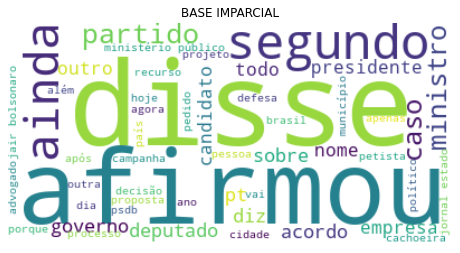

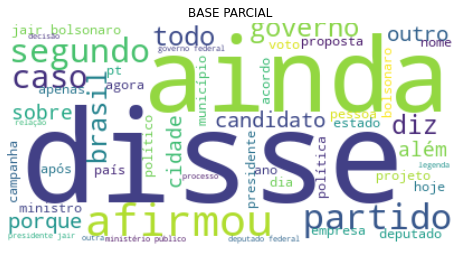

In [ ]:
print("PALAVRAS EM DESTAQUE DA BASE")

impartial_base = train[train['type'] == 'impartial']

impartial_unique_string = impartial_base['article_tokens'].apply(lambda text : (" ").join(text) )
impartial_frequency = FreqDist( impartial_unique_string )
impartial_word_dict = impartial_frequency.keys()

impartial_unique_string = (" ").join(impartial_word_dict)

wordcloud = WordCloud(
    stopwords=['não'],
    margin=0,
    max_words=50,
    background_color="white"
).generate( impartial_unique_string )

plt.figure(figsize=(8,6))
plt.title("BASE IMPARCIAL")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)



partial_base = train[train['type'] == 'partial']

partial_unique_string = partial_base['article_tokens'].apply(lambda text : (" ").join(text) )
partial_frequency = FreqDist( partial_unique_string )
partial_word_dict = partial_frequency.keys()

partial_unique_string = (" ").join(partial_word_dict)

wordcloud = WordCloud(
    stopwords=['não'],
    margin=0,
    max_words=50,
    background_color="white"
).generate( partial_unique_string )

plt.figure(figsize=(8,6))
plt.title("BASE PARCIAL")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)


### Preparação do MODELO

In [ ]:
if (MODEL_GENERATOR):
    embedding_matrix = create_embedding_matrix(Word2Vec, MAX_NB_WORDS, EMBEDDING_DIM)
    embedding_matrix.shape


In [ ]:
if (MODEL_GENERATOR):
    # pad_sequences é usado para garantir que todas as sequências em uma lista tenham o mesmo comprimento.
    # o comprimento será o maior valor entre os 75% da base
    X = pad_sequences(
        maxlen=max_len,
        sequences=train['article_tokens_word2vec'],
        value=0,
        padding='post',
        truncating='post'
    )

    # pandas get_dummies transforma em valor binário
    # pd.get_dummies([a, b, a])
    # result [ [1,0], [0,1], [1,0] ]
    Y = pd.get_dummies(train['type']).values
    (X.shape, Y.shape)


((10524, 2107), (10524, 2))

In [ ]:
if (MODEL_GENERATOR):
    # train_test_split - Divide arrays ou matrizes em arrays menores, aleatórios e com subconjuntos de teste
    # test_size=0.20 - Reservado 20% para teste
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42, stratify=Y)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)
    

(8419, 2107) (8419, 2)
(2105, 2107) (2105, 2)


In [ ]:
if (MODEL_GENERATOR):
    num_labels = Y.shape[1]

    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], weights=[embedding_matrix]))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.1))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2107, 50)          46480300  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 2107, 50)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 46,539,438
Trainable params: 46,539,438
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if (MODEL_GENERATOR):
    if Path(MODEL_IN).is_file():
        model.load_weights(MODEL_IN)
        

In [ ]:
if (MODEL_GENERATOR):
    epochs = 5
    batch_size = 1000

    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), CSVLogger(HISTORY_RESULTS, separator=';', append=True)])

    accr = model.evaluate(X_test,Y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

    model.save(MODEL_OUT)
    

Epoch 1/5
8/8 [==============================] - 191s 24s/step - loss: 0.6784 - accuracy: 0.5781 - val_loss: 0.6662 - val_accuracy: 0.6021
Epoch 2/5
8/8 [==============================] - 258s 34s/step - loss: 0.6681 - accuracy: 0.5913 - val_loss: 0.6595 - val_accuracy: 0.6081
Epoch 3/5
8/8 [==============================] - 223s 28s/step - loss: 0.6575 - accuracy: 0.6116 - val_loss: 0.6457 - val_accuracy: 0.6437
Epoch 4/5
8/8 [==============================] - 274s 37s/step - loss: 0.6431 - accuracy: 0.6346 - val_loss: 0.6348 - val_accuracy: 0.6508
Epoch 5/5
66/66 [==============================] - 18s 264ms/step - loss: 0.6150 - accuracy: 0.6632
Test set
  Loss: 0.615
  Accuracy: 0.663


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model_train_nb6.wv/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model_train_nb6.wv/assets


### Analise Historico Modelo


Epocas do Modelo - 5


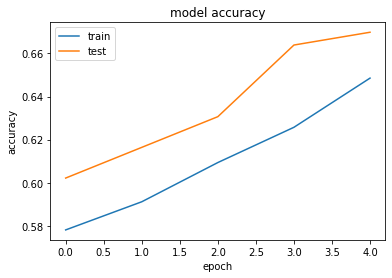

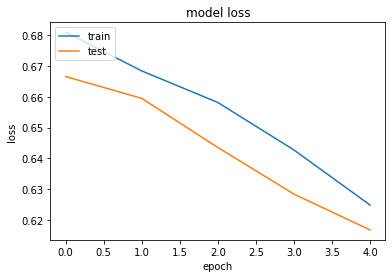

In [ ]:
history_results = pd.read_csv(HISTORY_RESULTS, sep=';')
print("\nEpocas do Modelo - " + str(len(history_results['accuracy'])) )

# summarize history for accuracy
plt.plot(history_results['accuracy'])
plt.plot(history_results['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_results['loss'])
plt.plot(history_results['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Testar o Modelo

In [ ]:
history_results = pd.read_csv(HISTORY_RESULTS, sep=';')
print("\nEpocas do Modelo - " + str(len(history_results['accuracy'])) )

model = load_model(MODEL_OUT)

dataGROUNDTRUTH = pd.read_csv(BASE_GROUND_TRUTH, sep=';', index_col=None, names=['article','type', 'id', 'length', 'count_neutral_words'])

countErro = 0
countAcerto = 0

count = {
    'acerto': {
        'impartial': 0,
        'partial': 0,
    },
    'erro': {
        'impartial': 0,
        'partial': 0,
    }
}

lenData = len(dataGROUNDTRUTH["article"])
print("Base de Teste gerada por Humano:\n -> Tamanho: " + str(lenData) + "\n")

for i in range(lenData):
    predict = predictModel(dataGROUNDTRUTH["article"][i], ["impartial", "partial"], Word2Vec)

    if(predict == dataGROUNDTRUTH["type"][i]):
        countAcerto = countAcerto + 1
        count['acerto'][predict] = count['acerto'][predict] + 1
    else:
        countErro = countErro + 1
        count['erro'][dataGROUNDTRUTH["type"][i]] = count['erro'][dataGROUNDTRUTH["type"][i]] + 1

print('\n.........................')

porAcu = (countAcerto / lenData)*100
print("Acurácia Total: " + str(porAcu) + "%")

porImp = (count['acerto']['impartial'] / (count['acerto']['impartial'] + count['erro']['impartial']))*100
porPar = (count['acerto']['partial'] / (count['acerto']['partial'] + count['erro']['partial']))*100

print("Acurácia Imparcial: " + str(porImp) + "%")
print("Acurácia Parcial: " + str(porPar) + "%")



Epocas do Modelo - 5
Base de Teste gerada por Humano:
 -> Tamanho: 140


.........................
Acurácia Total: 67.14285714285714%
Acurácia Imparcial: 70.0%
Acurácia Parcial: 60.0%


### Modelos Treinados

Model_Train_01.wv - 07 Epocas
- Acurácia Total: 61.42857142857143%
- Acurácia Imparcial: 60.0%
- Acurácia Parcial: 65.0%

Model_Train_02.wv - 05 Epocas
- Acurácia Total: 62.142857142857146%
- Acurácia Imparcial: 54.0%
- Acurácia Parcial: 82.5%

Model_Naive_Bayes_01.wv - 05 Epocas
- Acurácia Total: 67.14285714285714%
- Acurácia Imparcial: 70.0%
- Acurácia Parcial: 60.0%

Model_Naive_Bayes_02.wv - 10 Epocas
- Acurácia Total: 65.71428571428571%
- Acurácia Imparcial: 62.0%
- Acurácia Parcial: 75.0%
